In [2]:
import pandas as pd
df = pd.read_csv("TrazasHP_Eventos_Febrero.csv", delimiter=';')

In [3]:
level_filtered = df[df['Value.EventType'].str.contains('InicioNivelEvent') | df['Value.EventType'].str.contains('MuerteJugadorEvent') | df['Value.EventType'].str.contains('RecibirDanoEvent')]

from collections import defaultdict
# Guarda la vida perdida por run y por persona
lost_hp = defaultdict(list)
# Guarda los niveles que ha empezado por run y por persona
lvl_played_run = defaultdict(list)
# Al final se dividiran para extraer la vida perdida por nivel por run

run = 0
current_sid = ''
for ind in level_filtered.index:
    a = str(level_filtered['Name'][ind])
    if a not in current_sid:
        run = 0
        current_sid = a
        
    # Cada InicioNivelEvent suma un nivel al total en esa run
    if 'InicioNivelEvent' in level_filtered['Value.EventType'][ind]:
        # Cuando esta vacio o se aumenta de run, se hace un append a la lista
        if not lvl_played_run[a]:
            lvl_played_run[a].append(1)
        elif len(lvl_played_run[a]) is run:
            lvl_played_run[a].append(1)
        else:
            lvl_played_run[a][run] += 1
            
    elif 'RecibirDanoEvent' in level_filtered['Value.EventType'][ind]:
        if not lost_hp[a]:
            lost_hp[a].append(1)
        elif len(lost_hp[a]) is run:
            lost_hp[a].append(1)
        else:
            lost_hp[a][run] += 1
    
    # La unica manera de acabar la run es muriendo, asi se pasa a la siguiente
    elif 'MuerteJugadorEvent' in level_filtered['Value.EventType'][ind]:
        run += 1

In [4]:
# Estructura final que guarda vida perdida por nivel, con tantas entradas como runs
hp_level_runs = defaultdict(list)

for ind in lost_hp:
    aux = []
    if lvl_played_run[ind] and lost_hp[ind]:
        for i in range(0,len(lost_hp[ind])):
            aux.append(lost_hp[ind][i]/ lvl_played_run[ind][i])
        hp_level_runs[ind] = aux

In [22]:
df_forms = pd.read_csv("TrazasHP_Forms_Febrero.csv", delimiter=';')
skills = df_forms[['Name','Value.Skill', 'Value.levelDifficulty']].dropna()

skillsIDsEASY = defaultdict(list)
skillsIDsHARD = defaultdict(list)

for ind in skills.index:
    if 'EASY' in skills['Value.levelDifficulty'][ind]:
        skillsIDsEASY[skills['Name'][ind]].append(skills['Value.Skill'][ind])
    else:
        skillsIDsHARD[skills['Name'][ind]].append(skills['Value.Skill'][ind])

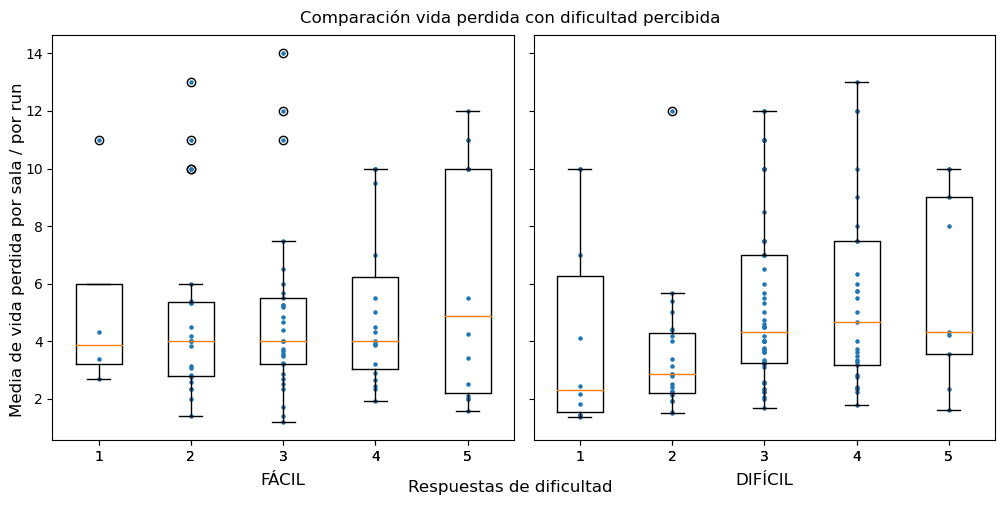

In [48]:
import matplotlib.pyplot as plt
import numpy as np

x = []
y = []

for ind in skillsIDsEASY:
    for i in range(0,len(skillsIDsEASY[ind])):
        if skillsIDsEASY[ind] and hp_level_runs[str(ind)]:
            x.append(skillsIDsEASY[ind][i])
            y.append(hp_level_runs[str(ind)][i])
            
data = [[],[],[],[],[]]

for i in range(0,len(x)):
    data[int(x[i]) - 1].append(y[i])

f, axs = plt.subplots(1, 2, sharey=True, sharex=True)
f.set_size_inches(10,5)

axs[0].boxplot(data)
axs[0].scatter(x,y, s=5)
axs[0].set_title("FÁCIL", y =-0.13)

x = []
y = []

for ind in skillsIDsHARD:
    for i in range(0,len(skillsIDsHARD[ind])):
        if skillsIDsHARD[ind] and hp_level_runs[str(ind)]:
            x.append(skillsIDsHARD[ind][i])
            y.append(hp_level_runs[str(ind)][i])
            
data = [[],[],[],[],[]]

for i in range(0,len(x)):
    data[int(x[i]) - 1].append(y[i])

axs[1].boxplot(data)
axs[1].scatter(x,y, s=5)
axs[1].set_title("DIFÍCIL", y =-0.13)

plt.tight_layout()

f.suptitle("Comparación vida perdida con dificultad percibida")
f.subplots_adjust(top=0.93)

f.supxlabel('Respuestas de dificultad')
f.supylabel('Media de vida perdida por sala / por run', x=0)

plt.savefig("Resultados/Vida-Forms_DIFICULTAD.pdf", format="pdf", bbox_inches="tight")

plt.show()